In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb ## XGBoost 불러오기
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.utils import to_categorical

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import os
os.chdir('C:/Users/User/Desktop/open')

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [5]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [6]:
train.shape

(26457, 20)

In [7]:
test.shape

(10000, 19)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
index            26457 non-null int64
gender           26457 non-null object
car              26457 non-null object
reality          26457 non-null object
child_num        26457 non-null int64
income_total     26457 non-null float64
income_type      26457 non-null object
edu_type         26457 non-null object
family_type      26457 non-null object
house_type       26457 non-null object
DAYS_BIRTH       26457 non-null int64
DAYS_EMPLOYED    26457 non-null int64
FLAG_MOBIL       26457 non-null int64
work_phone       26457 non-null int64
phone            26457 non-null int64
email            26457 non-null int64
occyp_type       18286 non-null object
family_size      26457 non-null float64
begin_month      26457 non-null float64
credit           26457 non-null float64
dtypes: float64(4), int64(8), object(8)
memory usage: 4.0+ MB


#데이터 전처리

In [9]:
#결측치 제거
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [10]:
train=train.drop('occyp_type', axis=1)
test=test.drop('occyp_type', axis=1)

In [11]:
#이진분류
train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------')
      
print('Having a phone or not: ')
print(train['phone'].value_counts())
print('--------------')
      

print('Having a email or not: ')
print(train['email'].value_counts())
print('--------------')
      

print('Having a work phone or not: ')
print(train['work_phone'].value_counts())
print('--------------')

gender :
0    17697
1     8760
Name: gender, dtype: int64
--------------
Having a car or not : 
0    16410
1    10047
Name: car, dtype: int64
--------------
Having house reality or not: 
1    17830
0     8627
Name: reality, dtype: int64
--------------
Having a phone or not: 
0    18672
1     7785
Name: phone, dtype: int64
--------------
Having a email or not: 
0    24042
1     2415
Name: email, dtype: int64
--------------
Having a work phone or not: 
0    20511
1     5946
Name: work_phone, dtype: int64
--------------


#연속형 수치 분류

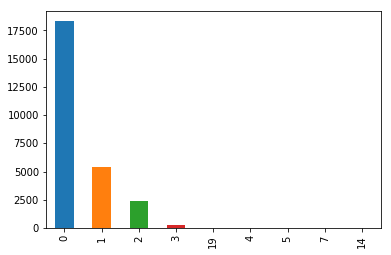

In [12]:
train['child_num'].value_counts(sort=False).plot.bar()

In [13]:
train.loc[train['child_num'] >= 2,'child_num']=2
test.loc[test['child_num']>=2, 'child_num']=2

(2.544, 18.18]      16212
(18.18, 33.66]       8330
(33.66, 49.14]       1530
(49.14, 64.62]        206
(64.62, 80.1]         121
(80.1, 95.58]          44
(95.58, 111.06]         3
(111.06, 126.54]        2
(126.54, 142.02]        4
(142.02, 157.5]         5
Name: income_total, dtype: int64


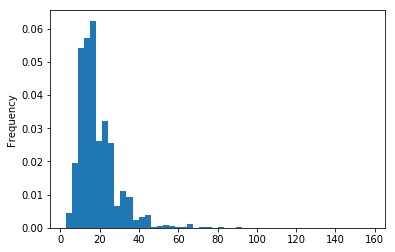

In [14]:
train['income_total'] = train['income_total'].astype(object)
train['income_total'] = train['income_total']/10000 
test['income_total'] = test['income_total']/10000
##############################################################3
print(train['income_total'].value_counts(bins=10,sort=False))
train['income_total'].plot(kind='hist',bins=50,density=True)

In [15]:
count, bin_dividers =np.histogram(train['income_total'], bins=7)
bin_names=['소득'+str(i) for i in range(7) ]
#bin_dividers는 train기준!!
train['income_total']=pd.cut(x=train['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)
test['income_total']=pd.cut(x=test['income_total'], bins=bin_dividers, labels=bin_names, include_lowest=True)

In [16]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,소득0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,2.0,-60.0
1,26458,0,0,1,0,소득0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,2.0,-36.0
2,26459,0,0,1,0,소득0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,2.0,-40.0
3,26460,1,1,0,0,소득0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,2.0,-41.0
4,26461,0,1,1,0,소득0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,2.0,-8.0
5,26462,0,1,1,0,소득0,Working,Secondary / secondary special,Single / not married,House / apartment,-18458,-2104,1,0,0,0,1.0,-5.0
6,26463,0,0,1,0,소득2,Commercial associate,Secondary / secondary special,Married,House / apartment,-18858,-2010,1,0,1,0,2.0,-1.0
7,26464,0,0,1,0,소득0,Pensioner,Higher education,Married,House / apartment,-20345,365243,1,0,1,0,2.0,-10.0
8,26465,0,0,0,0,소득0,Working,Secondary / secondary special,Single / not married,House / apartment,-19316,-4451,1,1,1,0,1.0,-23.0
9,26466,1,0,0,0,소득0,Working,Secondary / secondary special,Single / not married,With parents,-11873,-3504,1,0,0,0,1.0,-31.0


In [17]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [18]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
train['income_type']=label_encoder.fit_transform(train['income_type'])
test['income_type']=label_encoder.transform(test['income_type'])
########################################################################
train['edu_type']=label_encoder.fit_transform(train['edu_type'])
test['edu_type']=label_encoder.transform(test['edu_type'])
########################################################################
train['family_type']=label_encoder.fit_transform(train['family_type'])
test['family_type']=label_encoder.transform(test['family_type'])
########################################################################
train['house_type']=label_encoder.fit_transform(train['house_type'])
test['house_type']=label_encoder.transform(test['house_type'])
########################################################################
train['income_total']=label_encoder.fit_transform(train['income_total'])
test['income_total']=label_encoder.fit_transform(test['income_total'])

In [19]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,-13899,-4709,1,0,0,0,2.0,-6.0,1.0
1,1,0,0,1,1,0,0,4,0,1,-11380,-1540,1,0,0,1,3.0,-5.0,1.0
2,2,1,1,1,0,1,4,1,1,1,-19087,-4434,1,0,1,0,2.0,-22.0,2.0
3,3,0,0,1,0,0,0,4,1,1,-15088,-2092,1,0,1,0,2.0,-37.0,0.0
4,4,0,1,1,0,0,2,1,1,1,-15037,-2105,1,0,0,0,2.0,-26.0,2.0
5,5,0,0,1,2,1,4,4,1,1,-13413,-4996,1,0,0,1,4.0,-18.0,1.0
6,6,0,0,0,0,1,4,4,2,1,-17570,-1978,1,0,0,1,1.0,-41.0,2.0
7,7,1,0,1,0,1,0,4,1,1,-14896,-5420,1,0,0,1,2.0,-53.0,0.0
8,8,1,1,1,1,0,0,1,1,1,-15131,-1466,1,0,0,1,3.0,-38.0,2.0
9,9,0,0,1,0,0,4,4,1,1,-15785,-1308,1,0,0,0,2.0,-5.0,2.0


In [20]:
#음수값 변환
#minus 변경하고
#구간화 함수
def make_bin(variable, n):
    train[variable]=-train[variable]
    test[variable]=-test[variable]
    count, bin_dividers =np.histogram(train[variable], bins=n) #train의 구간화를 적용
    bin_names=[str(i) for i in range(n)]
    train[variable]=pd.cut(x=train[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable]=pd.cut(x=test[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    test[variable].fillna(str(0), inplace=True) #test에는 없는 것을 임의의 값으로 채움
    ##########################################################
    train[variable]=label_encoder.fit_transform(train[variable])
    test[variable]=label_encoder.transform(test[variable])

In [21]:
train.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'family_size', 'begin_month', 'credit'],
      dtype='object')

In [22]:
make_bin('DAYS_BIRTH', n=20)
make_bin('DAYS_EMPLOYED', n=16)
make_bin('begin_month', n=12)

In [23]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
0,0,0,0,0,0,0,0,1,1,2,17,1,1,0,0,0,2.0,1,1.0
1,1,0,0,1,1,0,0,4,0,1,14,1,1,0,0,1,3.0,0,1.0
2,2,1,1,1,0,1,4,1,1,1,5,1,1,0,1,0,2.0,6,2.0
3,3,0,0,1,0,0,0,4,1,1,18,1,1,0,1,0,2.0,9,0.0
4,4,0,1,1,0,0,2,1,1,1,18,1,1,0,0,0,2.0,7,2.0
5,5,0,0,1,2,1,4,4,1,1,16,1,1,0,0,1,4.0,5,1.0
6,6,0,0,0,0,1,4,4,2,1,3,1,1,0,0,1,1.0,10,2.0
7,7,1,0,1,0,1,0,4,1,1,18,1,1,0,0,1,2.0,2,0.0
8,8,1,1,1,1,0,0,1,1,1,18,1,1,0,0,1,3.0,9,2.0
9,9,0,0,1,0,0,4,4,1,1,19,1,1,0,0,0,2.0,0,2.0


In [24]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month
0,26457,1,1,0,0,0,1,4,0,1,8,0,1,0,1,0,2.0,3
1,26458,0,0,1,0,0,2,1,1,1,4,1,1,0,1,0,2.0,9
2,26459,0,0,1,0,0,4,4,1,1,19,1,1,1,1,0,2.0,9
3,26460,1,1,0,0,0,0,4,1,1,5,1,1,1,0,0,2.0,10
4,26461,0,1,1,0,0,2,1,1,1,3,1,1,1,0,0,2.0,1
5,26462,0,1,1,0,0,4,4,3,1,4,1,1,0,0,0,1.0,0
6,26463,0,0,1,0,2,0,4,1,1,4,1,1,0,1,0,2.0,0
7,26464,0,0,1,0,0,1,1,1,1,6,0,1,0,1,0,2.0,1
8,26465,0,0,0,0,0,4,4,3,1,5,1,1,1,1,0,1.0,6
9,26466,1,0,0,0,0,4,4,3,5,14,1,1,0,0,0,1.0,8


#데이터 모델링

In [25]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [26]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 18) (26457, 1) (10000, 18)


In [27]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.1,
                                                    random_state = 10086)

#0 ~ 1 값으로 scaling
scaler = MinMaxScaler()

#사용할 모델로 XGBoost를 채택
base_model = XGBClassifier(random_state=1)

#10-fold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

pipe = Pipeline(steps=[('scaler', scaler), ('base_model', base_model)])

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Val set: ")
print(X_val.shape)
print(y_val.shape)

Train set: 
(23811, 18)
(23811, 1)
Val set: 
(2646, 18)
(2646, 1)


In [28]:
params = {
             'eval_metric' : 'mlogloss',
             'objective' : 'multi:softprob',
             'num_class' : 3 
         }

best_params_grid = {
    'base_model__n_estimators' : [50, 100, 200, 400],
    'base_model__learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'base_model__max_depth' : [4, 6, 8, 10, 12]
}

In [29]:
def run_xgboost(pipe):

    outcomes=[]
    
    best_grid_model = GridSearchCV(estimator=pipe,
                              param_grid=best_params_grid,
                              cv=kfold,
                              iid=True,
                              n_jobs=-1).fit(train_x, train_y)
    
    y_pred = best_grid_model.predict_proba(X_val)
    print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_pred)}")
    
    #제출용 답안에 컬럼[0, 1, 2]의 모든 row을 0으로 초기화
    sub=np.zeros((test_x.shape[0], 3))

    predictions = np.round(best_grid_model.predict_proba(X_val), 3)

    logloss=log_loss(to_categorical(y_val['credit']), predictions)
    outcomes.append(logloss)
    mean_outcome=np.mean(outcomes)
    
    sub = np.round(best_grid_model.predict_proba(test_x), 3)
    
    print("Mean:{}".format(mean_outcome))

    return sub

my_submission = run_xgboost(pipe)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[22:13:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log_loss: 0.7717089969622575
Mean:0.7716928512668934


In [30]:
my_submission

array([[0.033, 0.261, 0.705],
       [0.035, 0.101, 0.864],
       [0.043, 0.229, 0.727],
       ...,
       [0.043, 0.12 , 0.837],
       [0.054, 0.099, 0.847],
       [0.022, 0.109, 0.869]], dtype=float32)

In [31]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
5,26462,0,0,0
6,26463,0,0,0
7,26464,0,0,0
8,26465,0,0,0
9,26466,0,0,0


In [32]:
submission.loc[:,1:]=my_submission

In [33]:
submission

,index,0,1,2
0,26457,0.033,0.261,0.705
1,26458,0.035,0.101,0.864
2,26459,0.043,0.229,0.727
3,26460,0.063,0.149,0.789
4,26461,0.036,0.144,0.820
5,26462,0.147,0.309,0.544
6,26463,0.359,0.354,0.287
7,26464,0.036,0.259,0.705
8,26465,0.032,0.189,0.778
9,26466,0.041,0.167,0.791


In [34]:
os.chdir('C:/Users/User/Desktop/open')

In [35]:
submission.to_csv('submission.csv', index=False)

In [36]:
train.to_csv('train2.csv', index=False)
test.to_csv('test2.csv', index=False)